# This notebook is designed to try and create heat maps for h-abstraction reactions on biofules

In [1]:
from rmgpy.molecule import Molecule, Bond, Atom
from rmgpy.reaction import Reaction
from rmgpy.kinetics import Arrhenius, MultiArrhenius

import rdkit
import inspect
from rmgpy.qm.molecule import QMMolecule, Geometry
from rmgpy.qm.main import QMSettings
import os
import re
from collections import defaultdict, OrderedDict
import pandas as pd

%matplotlib inline

import matplotlib
import numpy as np
import sympy
import matplotlib.pyplot as plt
from matplotlib.collections import EllipseCollection 


In [5]:
# Getting Kinetics and Reactions from log file
scratch_directory = "/gss_gpfs_scratch/harms.n/bioTST/"
results = defaultdict(OrderedDict)
i = 0
for file in os.listdir(scratch_directory):
    if file.endswith(".log") and file.startswith("AutoTST"):
        r = results[i]
        file_name = os.path.join(scratch_directory, file)
        with open(file_name, "r") as f:
            lines = f.readlines()
            for line in lines:
                m = re.match('biofuelsTST.py:186 performCalcs INFO chemkinRxn: (.*)', line)
                if m:
                    rxn = eval(m.group(1))
                    r['Reaction'] = rxn 
                    max_weight = 0
                    for reactant in rxn.reactants:
                        for product in rxn.products:
                            weight = reactant.getMolecularWeight() + product.getMolecularWeight()
                            if weight > max_weight:
                                max_weight = weight
            
                                final_pair = (reactant, product)
                                if reactant.isRadical():
                                    r["Radical Molecule"] = reactant
                                    r["Base Molecule"] = product.toSMILES()
                                    radical = reactant
                                else:
                                    r["Radical Molecule"] = product
                                    r["Base Molecule"] = reactant.toSMILES()
                                    radical = product
                                
                                    

                
                n = re.match('We have calculated kinetics (.*)', line)
                if n:
                    kinetics = eval(n.group(1))
                    r["Arrhenius Expression"] = kinetics
                    r["Kinetics at 1000K, 100bar"] = np.log(kinetics.getRateCoefficient(T=1000, P=100))
                
                
            j = 0

            for j in range(len(radical.__getAtoms())):
                atom = radical.__getAtoms()[j]
                if atom.radicalElectrons != 0:
                    r["Radical Number ID"] = j
                    
                    
        i +=1
df = pd.DataFrame(results).T
df = df.set_index(df["Base Molecule"])


In [6]:
list_of_smiles = [
    "CC(C)CC(C)(C)C",
    "CCCCC(C)CC",
    "CCC(C)CC(C)C",
    "CCC(C)(C)O",
    "OCC(C)CCC",
    "CCCC(C)C=C(C)C",
    "CC1CCCC1",
    "C=C\C(=C\CCC(=C)C)C",
    "CC1=CC=C(C)C=C1",
    "CC(C)CC(=O)CC(C)C",
    "CC(C)CC(C)C(=O)C",
    "CC(C)(C)OCC(CO)OC(C)(C)C",
    "CCC(CC)OC(C)C",
    "CC1=CCC2CC1C2(C)C",
    "CC(C)CCOC(C)=O",
    "CCOC(=O)C(C)C",
    "CC1=CCCC1=O",
    "CCCCCC1CCC(C)O1",
    "CCCCC=C(C)C",
    "CCCC=CC(C)C",
    "CCC=CCC(C)C",
    "CC=CCCC(C)C",
    "C=CCCCC(C)C"
]

CC(C)CC(C)(C)C
1 0
7 1
1 2
0 3
1 4
1 5
1 6
1 7
1 8
1 9
0 10
3 11
1 12
0 13
1 14
1 15
0 16
0 17
1 18
1 19
0 2 SINGLE
0 3 SINGLE
0 4 SINGLE
0 5 SINGLE
1 2 SINGLE
1 7 SINGLE
1 6 SINGLE
CCCCC(C)CC
7 0
7 1
7 2
7 3
7 4
0 5
7 6
7 7
0 8
7 9
7 10
7 11
7 12
7 13
7 14
0 15
7 16
0 17
1 18
7 19
0 20
7 21
0 22
7 23
0 24
1 25
7 26
7 27
7 28
3 29
7 30
0 31
7 32
0 33
0 34
0 35
7 36
0 37
7 38
2 39
0 1 SINGLE
0 3 SINGLE
0 5 SINGLE
1 2 SINGLE
2 4 SINGLE
3 7 SINGLE
4 6 SINGLE
CCC(C)CC(C)C
0 0
2 1
2 2
0 3
2 4
0 5
2 6
0 7
0 8
2 9
0 10
0 11
2 12
7 13
0 14
2 15
0 16
7 17
2 18
2 19
2 20
2 21
2 22
2 23
0 24
0 25
2 26
4 27
2 28
1 29
2 30
2 31
0 32
2 33
2 34
0 2 SINGLE
0 4 SINGLE
0 3 SINGLE
1 2 SINGLE
1 5 SINGLE
1 6 SINGLE
3 7 SINGLE
CCC(C)(C)O
1 0
0 1
5 2
1 3
1 4
1 5
1 6
1 7
5 8
1 9
1 10
5 11
0 12
1 13
1 14
1 15
1 16
1 17
1 18
1 19
0 3 SINGLE
0 5 SINGLE
0 1 SINGLE
0 2 SINGLE
1 4 SINGLE
OCC(C)CCC
0 0
3 1
3 2
0 3
3 4
3 5
6 6
3 7
3 8
3 9
6 10
3 11
3 12
5 13
3 14
3 15
6 16
2 17
2 18
3 19
0 20
3 21
3 22
3 23
2 24
0 25

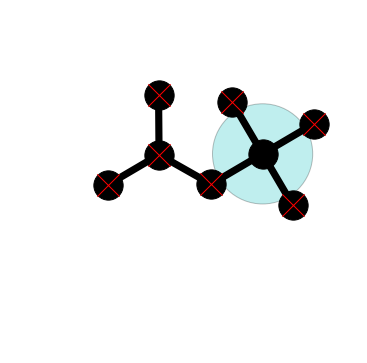

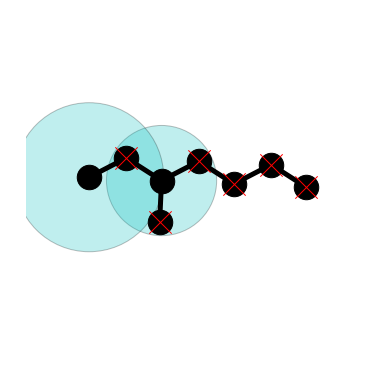

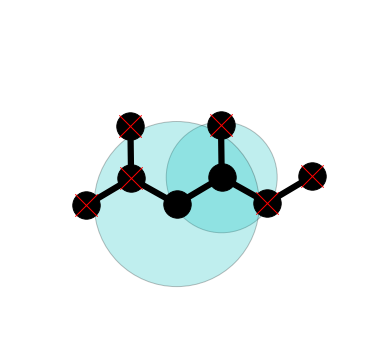

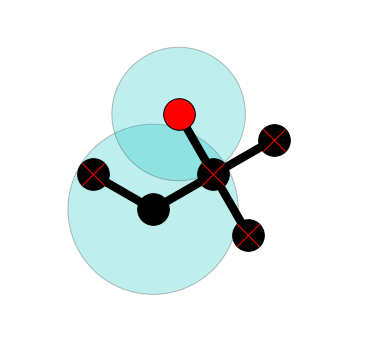

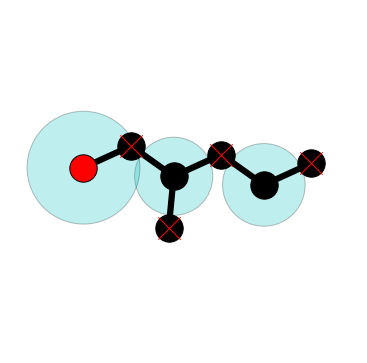

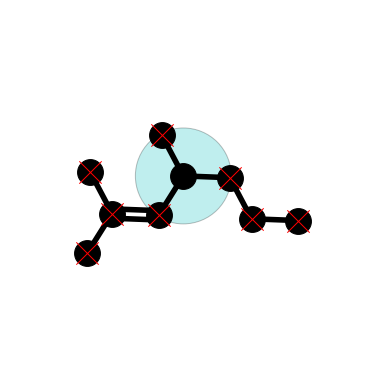

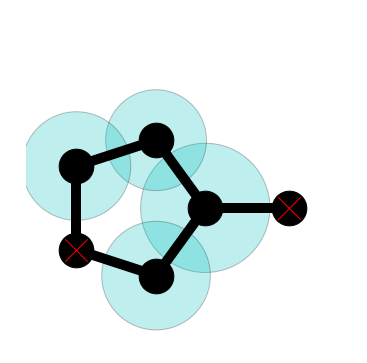

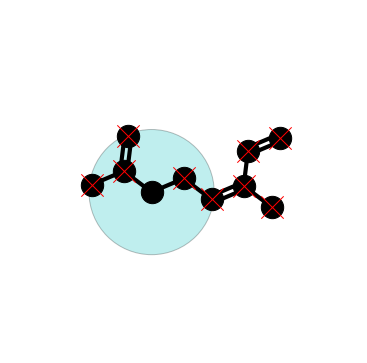

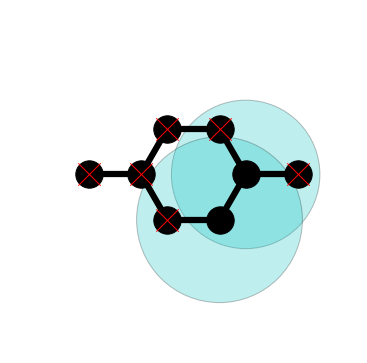

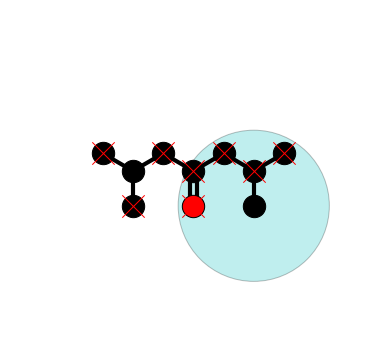

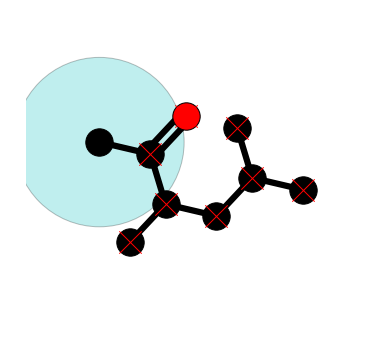

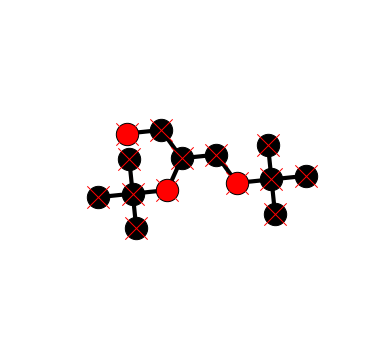

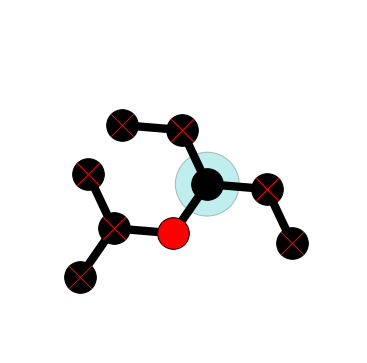

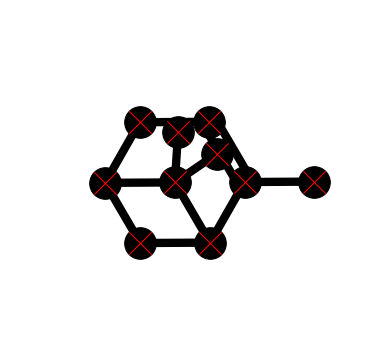

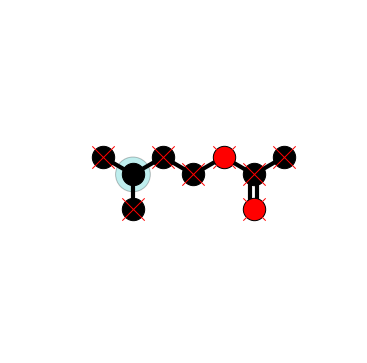

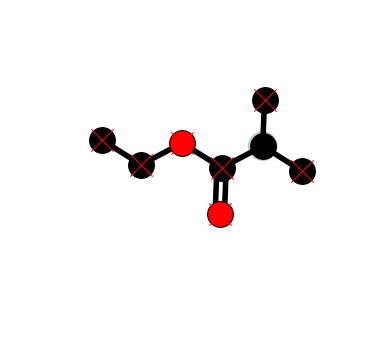

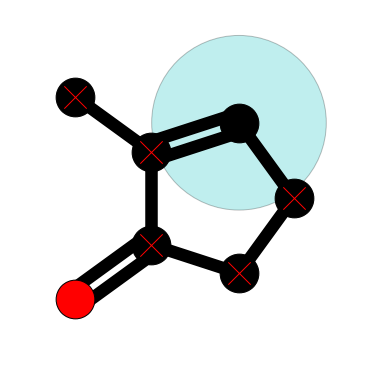

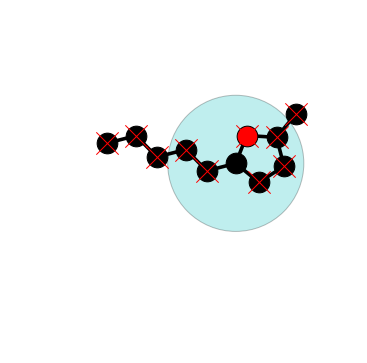

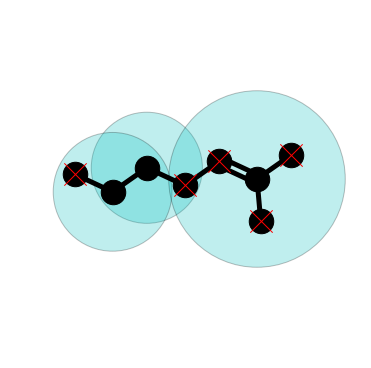

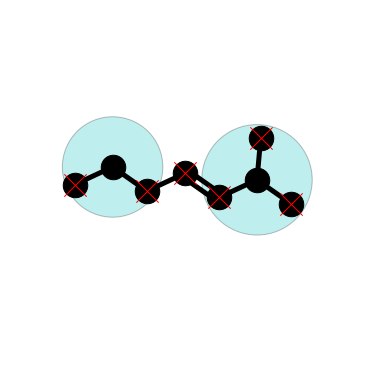

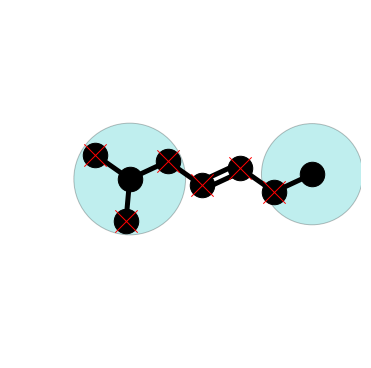

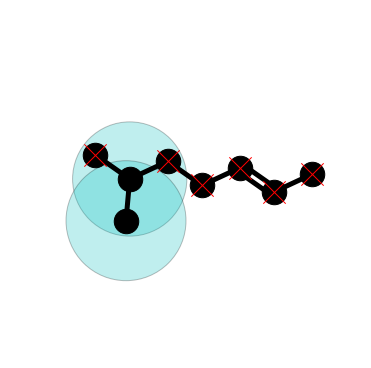

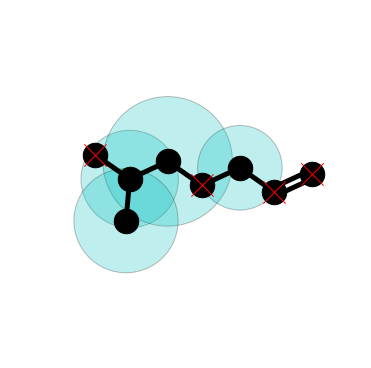

In [37]:
for smiles in list_of_smiles:
    print smiles
    rmg_mol = Molecule(SMILES=smiles)
    rmg_smiles = rmg_mol.toSMILES()
    
    rdmol = rmg_mol.toRDKitMol()
    rdmol.Compute2DCoords()
    tup = rdmol.GetConformers()
    rdconformer = tup[0]
    rates = np.zeros(rdconformer.GetNumAtoms())
    k = 0
    for number in df.loc[rmg_smiles]["Radical Number ID"]:
        print number, k
        #print df.loc[smiles]["Kinetics at 1000K, 100bar"][k]
        if not np.isnan(df.loc[rmg_smiles]["Kinetics at 1000K, 100bar"][k]) and rates[number] == 0:
            rates[number] = df.loc[rmg_smiles]["Kinetics at 1000K, 100bar"][k] *2000
            #print df.loc[rmg_smiles]["Kinetics at 1000K, 100bar"][k]
        elif rates[number] != 0:
            #print "Previous rate"
            #print rates[number]
            #print df.loc[rmg_smiles]["Kinetics at 1000K, 100bar"][k]
            r = rates[number] 
            if r < df.loc[rmg_smiles]["Kinetics at 1000K, 100bar"][k] *2000:
                rates[number] = df.loc[rmg_smiles]["Kinetics at 1000K, 100bar"][k]*2000
        #print rates[number]
        #print
        k +=1
    #for atom in rdmol.Atoms:
    #igure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
    fig, ax = plt.subplots(figsize=(6,6), dpi=120)

    x=[]
    y=[]


    for i in range(rdconformer.GetNumAtoms()):
        indx = rdmol.GetAtomWithIdx(i).GetIdx()
        #print rdmol.GetAtoms()[i].GetAtomicNum()
        #print rdconformer.GetAtomPosition(i).x, rdconformer.GetAtomPosition(i).y, rdconformer.GetAtomPosition(i).z
        x.append(rdconformer.GetAtomPosition(indx).x)
        y.append(rdconformer.GetAtomPosition(indx).y)

    ax.scatter(x,y, s=rates, c='c', alpha=0.25, zorder=0)
    
    for i in range(len(rates)):
        rate = rates[i]
        if rate == 0:
            ax.scatter(x[i], y[i], marker="x", s=500, c="r", zorder=10000)

    ax.set_aspect('equal')
    lim = ax.get_xlim()
    lim2 = ax.get_ylim()
    if lim > lim2:
        lim = lim2
    diff = abs(lim[0] - lim[1])
    size = 12000 / (2*diff)
    thick = 50./ ( diff)

    minimum = np.min((ax.get_xlim(),ax.get_ylim()))
    maximum = np.max((ax.get_xlim(),ax.get_ylim()))

        # ToDo: Fix for double, triple bonds

    ax.set_xlim(minimum*1.2,maximum*1.2)
    ax.set_ylim(minimum*1.2,maximum*1.2)


    for bond in rdmol.GetBonds():
        print bond.GetBeginAtomIdx(), bond.GetEndAtomIdx(), bond.GetBondType()
        if str(bond.GetBondType()) == "SINGLE" or str(bond.GetBondType()) == "AROMATIC" :
            new_x = [x[bond.GetBeginAtomIdx()], x[bond.GetEndAtomIdx()]]
            new_y = [y[bond.GetBeginAtomIdx()], y[bond.GetEndAtomIdx()]]
            plt.plot(new_x, new_y, "k", alpha=1,zorder=1, linewidth=thick)
        elif str(bond.GetBondType()) == "DOUBLE":
            rise = y[bond.GetBeginAtomIdx()] - y[bond.GetEndAtomIdx()]
            run = x[bond.GetBeginAtomIdx()] - x[bond.GetEndAtomIdx()]


            del_y = sympy.Symbol('del_y')
            try:
                a = sympy.solvers.solve(0.1**2 - (- (rise/run) * del_y)**2 - del_y**2, del_y)
                del_x = - (rise/run) * a[0]
                v_1 = 0.15 * del_x / (del_x**2 + a[0]**2)**0.5
                v_2 = 0.15 * a[0] / (del_x**2 + a[0]**2)**0.5
            except ZeroDivisionError:
                v_1 = 0.15
                v_2 = 0




            new_x = [x[bond.GetBeginAtomIdx()] + v_1, x[bond.GetEndAtomIdx()] + v_1]
            new_y = [y[bond.GetBeginAtomIdx()] + v_2, y[bond.GetEndAtomIdx()] + v_2]
            newnew_x = [x[bond.GetBeginAtomIdx()] - v_1, x[bond.GetEndAtomIdx()] - v_1]
            newnew_y = [y[bond.GetBeginAtomIdx()] - v_2, y[bond.GetEndAtomIdx()] - v_2]
            plt.plot(new_x, new_y, "k", alpha=1, zorder=1, linewidth=thick)
            plt.plot(newnew_x, newnew_y, "k", alpha=1, zorder=1, linewidth=thick)
        elif str(bond.GetBondType()) == "TRIPLE":

            rise = y[bond.GetBeginAtomIdx()] - y[bond.GetEndAtomIdx()]
            run = x[bond.GetBeginAtomIdx()] - x[bond.GetEndAtomIdx()]


            del_y = sympy.Symbol('del_y')
            a = sympy.solvers.solve(0.1**2 - (- (rise/run) * del_y)**2 - del_y**2, del_y)
            del_x = - (rise/run) * a[0]
            dell_x = - (rise/run) * a[1]
            v_1 = 0.24 * del_x / (del_x**2 + a[0]**2)**0.5
            v_2 = 0.24 * a[0] / (del_x**2 + a[0]**2)**0.5

            new_x = [x[bond.GetBeginAtomIdx()], x[bond.GetEndAtomIdx()]]
            new_y = [y[bond.GetBeginAtomIdx()], y[bond.GetEndAtomIdx()]]
            newnew_x = [x[bond.GetBeginAtomIdx()] + v_1, x[bond.GetEndAtomIdx()] + v_1]
            newnew_y = [y[bond.GetBeginAtomIdx()] + v_2, y[bond.GetEndAtomIdx()] + v_2]
            newnewnew_x = [x[bond.GetBeginAtomIdx()] - v_1, x[bond.GetEndAtomIdx()] - v_1]
            newnewnew_y = [y[bond.GetBeginAtomIdx()] - v_2, y[bond.GetEndAtomIdx()] - v_2]
            plt.plot(new_x, new_y, "k", alpha=1, zorder=1, linewidth=thick)
            plt.plot(newnew_x, newnew_y, "k", alpha=1, zorder=1, linewidth=thick)
            plt.plot(newnewnew_x, newnewnew_y, "k", alpha=1, zorder=1, linewidth=thick)





    plt.axis("off")


    for i in range(rdconformer.GetNumAtoms()):
        indx = rdmol.GetAtomWithIdx(i).GetIdx()
        if rdmol.GetAtoms()[i].GetAtomicNum() == 6:
            plt.scatter(rdconformer.GetAtomPosition(indx).x, rdconformer.GetAtomPosition(indx).y, c="k", s=size, alpha=1, zorder=10)
        elif rdmol.GetAtoms()[i].GetAtomicNum() == 7:
            plt.scatter(rdconformer.GetAtomPosition(indx).x, rdconformer.GetAtomPosition(indx).y, c="b", s=size, alpha=1, zorder=10)
        elif rdmol.GetAtoms()[i].GetAtomicNum() == 8:
            plt.scatter(rdconformer.GetAtomPosition(indx).x, rdconformer.GetAtomPosition(indx).y, c="r", s=size, alpha=1, zorder=10)




0 1 SINGLE
1 2 SINGLE
2 3 SINGLE
3 4 SINGLE
4 5 SINGLE
1 6 SINGLE
6 7 SINGLE
7 8 SINGLE
8 9 SINGLE


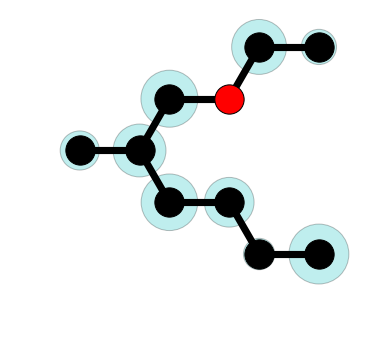

In [36]:

smiles = "CC(COCC)CCCC"
try:
    rdmol = rdkit.Chem.AllChem.MolFromSmiles(smiles)
except:
    rdmol = rdkit.Chem.AllChem.MolFromInchi(smiles)
rdmol.Compute2DCoords()
tup = rdmol.GetConformers()
rdconformer = tup[0]
rates = np.random.rand(rdconformer.GetNumAtoms())*4000 #figure out how to get rates
#for atom in rdmol.Atoms:
#igure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
fig, ax = plt.subplots(figsize=(6,6), dpi=120)

x=[]
y=[]


for i in range(rdconformer.GetNumAtoms()):
    indx = rdmol.GetAtomWithIdx(i).GetIdx()
    #print rdmol.GetAtoms()[i].GetAtomicNum()
    #print rdconformer.GetAtomPosition(i).x, rdconformer.GetAtomPosition(i).y, rdconformer.GetAtomPosition(i).z
    x.append(rdconformer.GetAtomPosition(indx).x)
    y.append(rdconformer.GetAtomPosition(indx).y)
    
ax.scatter(x,y, s=rates, c='c', alpha=0.25, zorder=0)
    
ax.set_aspect('equal')
lim = ax.get_xlim()
lim2 = ax.get_ylim()
if lim > lim2:
    lim = lim2
diff = abs(lim[0] - lim[1])
size = 12000 / (2*diff)
thick = 50./ ( diff)

minimum = np.min((ax.get_xlim(),ax.get_ylim()))
maximum = np.max((ax.get_xlim(),ax.get_ylim()))
    
    # ToDo: Fix for double, triple bonds

ax.set_xlim(minimum*1.2,maximum*1.2)
ax.set_ylim(minimum*1.2,maximum*1.2)


for bond in rdmol.GetBonds():
    print bond.GetBeginAtomIdx(), bond.GetEndAtomIdx(), bond.GetBondType()
    if str(bond.GetBondType()) == "SINGLE":
        new_x = [x[bond.GetBeginAtomIdx()], x[bond.GetEndAtomIdx()]]
        new_y = [y[bond.GetBeginAtomIdx()], y[bond.GetEndAtomIdx()]]
        plt.plot(new_x, new_y, "k", alpha=1,zorder=1, linewidth=thick)
    elif str(bond.GetBondType()) == "DOUBLE":
        rise = y[bond.GetBeginAtomIdx()] - y[bond.GetEndAtomIdx()]
        run = x[bond.GetBeginAtomIdx()] - x[bond.GetEndAtomIdx()]
        

        del_y = sympy.Symbol('del_y')
        try:
            a = sympy.solvers.solve(0.1**2 - (- (rise/run) * del_y)**2 - del_y**2, del_y)
            del_x = - (rise/run) * a[0]
            v_1 = 0.15 * del_x / (del_x**2 + a[0]**2)**0.5
            v_2 = 0.15 * a[0] / (del_x**2 + a[0]**2)**0.5
        except ZeroDivisionError:
            v_1 = 0.15
            v_2 = 0
            
        
    
        
        new_x = [x[bond.GetBeginAtomIdx()] + v_1, x[bond.GetEndAtomIdx()] + v_1]
        new_y = [y[bond.GetBeginAtomIdx()] + v_2, y[bond.GetEndAtomIdx()] + v_2]
        newnew_x = [x[bond.GetBeginAtomIdx()] - v_1, x[bond.GetEndAtomIdx()] - v_1]
        newnew_y = [y[bond.GetBeginAtomIdx()] - v_2, y[bond.GetEndAtomIdx()] - v_2]
        plt.plot(new_x, new_y, "k", alpha=1, zorder=1, linewidth=thick)
        plt.plot(newnew_x, newnew_y, "k", alpha=1, zorder=1, linewidth=thick)
    elif str(bond.GetBondType()) == "TRIPLE":
        
        rise = y[bond.GetBeginAtomIdx()] - y[bond.GetEndAtomIdx()]
        run = x[bond.GetBeginAtomIdx()] - x[bond.GetEndAtomIdx()]
        

        del_y = sympy.Symbol('del_y')
        a = sympy.solvers.solve(0.1**2 - (- (rise/run) * del_y)**2 - del_y**2, del_y)
        del_x = - (rise/run) * a[0]
        dell_x = - (rise/run) * a[1]
        v_1 = 0.24 * del_x / (del_x**2 + a[0]**2)**0.5
        v_2 = 0.24 * a[0] / (del_x**2 + a[0]**2)**0.5
        
        new_x = [x[bond.GetBeginAtomIdx()], x[bond.GetEndAtomIdx()]]
        new_y = [y[bond.GetBeginAtomIdx()], y[bond.GetEndAtomIdx()]]
        newnew_x = [x[bond.GetBeginAtomIdx()] + v_1, x[bond.GetEndAtomIdx()] + v_1]
        newnew_y = [y[bond.GetBeginAtomIdx()] + v_2, y[bond.GetEndAtomIdx()] + v_2]
        newnewnew_x = [x[bond.GetBeginAtomIdx()] - v_1, x[bond.GetEndAtomIdx()] - v_1]
        newnewnew_y = [y[bond.GetBeginAtomIdx()] - v_2, y[bond.GetEndAtomIdx()] - v_2]
        plt.plot(new_x, new_y, "k", alpha=1, zorder=1, linewidth=thick)
        plt.plot(newnew_x, newnew_y, "k", alpha=1, zorder=1, linewidth=thick)
        plt.plot(newnewnew_x, newnewnew_y, "k", alpha=1, zorder=1, linewidth=thick)
        
    
    


plt.axis("off")


for i in range(rdconformer.GetNumAtoms()):
    indx = rdmol.GetAtomWithIdx(i).GetIdx()
    if rdmol.GetAtoms()[i].GetAtomicNum() == 6:
        plt.scatter(rdconformer.GetAtomPosition(indx).x, rdconformer.GetAtomPosition(indx).y, c="k", s=size, alpha=1, zorder=10)
    elif rdmol.GetAtoms()[i].GetAtomicNum() == 7:
        plt.scatter(rdconformer.GetAtomPosition(indx).x, rdconformer.GetAtomPosition(indx).y, c="b", s=size, alpha=1, zorder=10)
    elif rdmol.GetAtoms()[i].GetAtomicNum() == 8:
        plt.scatter(rdconformer.GetAtomPosition(indx).x, rdconformer.GetAtomPosition(indx).y, c="r", s=size, alpha=1, zorder=10)




In [22]:
rdmol.RemoveAllConformers()

In [23]:
rdmol.AddConformer(rdconformer)

0

In [35]:
rdmol
for i in range(len(rdmol.GetAtoms())):
    indx = rdmol.GetAtomWithIdx(i).GetIdx()
    print rdconformer.GetAtomPosition(indx).x

-2.28098987632
-0.920653603802
0.306884534601
1.66722080712
-3.50852801473
-2.41378801045
2.89475894553
4.25509521805


In [33]:
atommm.GetIdx()

7